## Running the MIDAA on the Beta Cells dataset

In [71]:
import torch
import numpy as np
from scipy.spatial.distance import squareform, pdist
import scanpy as sc
import os

### Load the dataset

In [72]:

# 1. Load Data
print("Loading single-cell dataset...")
adata_beta_hfd = sc.read_h5ad('data/beta_cells_hfd.h5ad')

# show size of dataset
print(f"Dataset shape: {adata_beta_hfd.X.shape}")

adata_beta_hfd

Loading single-cell dataset...
Dataset shape: (3887, 16483)


AnnData object with n_obs × n_vars = 3887 × 16483
    obs: 'sample'
    var: 'human_name', 'ids'

### Subsample

In [73]:
# Dataset is too big, subsample for faster testing
adata_beta_hfd = adata_beta_hfd[:1000, :]
print(f"Subsampled dataset shape: {adata_beta_hfd.X.shape}")

Subsampled dataset shape: (1000, 16483)


### Load runs do charneca

In [74]:

SAVE_PATH = "/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/Midaa/MIDAA_all_runs.pth"
N_RUNS = 3
N_ARCHETYPES = 4
SAVE_DIR = "/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/Midaa/results"

## Visualize the results

In [75]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

# After loading MIDAA results
results = torch.load(SAVE_PATH, weights_only=False)

# Get the best run based on reconstruction error or just use first run
C_midaa = to_numpy(results['C_list'][0])  # (n_samples, n_archetypes)
S_midaa = to_numpy(results['S_list'][0])  # (n_archetypes, n_samples)
X_data = to_numpy(results['X'])           # Your actual data

print(f"C shape: {C_midaa.shape}")  # Should be (1000, 4)
print(f"S shape: {S_midaa.shape}")  # Should be (4, 1000)
print(f"X shape: {X_data.shape}")   # Should be (1000, n_features)

# ===========================================================================
# COMPUTE ARCHETYPES DIRECTLY - MIDAA ALREADY WORKS IN DATA SPACE
# ===========================================================================
# In MIDAA: X ≈ C @ S @ X
# So archetypes are: A = S @ X (each archetype is a convex combo of data points)
archetypes_midaa = S_midaa @ X_data  # (4, n_features)

print(f"\nArchetypes shape: {archetypes_midaa.shape}")
print(f"Expected: ({N_ARCHETYPES}, {X_data.shape[1]})")

# ===========================================================================
# VERIFY RECONSTRUCTION
# ===========================================================================
X_reconstructed = C_midaa @ archetypes_midaa  # (1000, 4) @ (4, n_features)

mse = np.mean((X_data - X_reconstructed)**2)
rmse = np.sqrt(mse)
r2 = r2_score(X_data.flatten(), X_reconstructed.flatten())

print(f"\nReconstruction Metrics:")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R2: {r2:.6f}")

# ===========================================================================
# VERIFY CONVEX HULL PROPERTIES
# ===========================================================================
print(f"\nS row sums (should be ~1): {S_midaa.sum(axis=1)}")
print(f"C row sums (should be ~1, first 5): {C_midaa.sum(axis=1)[:5]}")
print(f"C min/max: [{C_midaa.min():.4f}, {C_midaa.max():.4f}]")
print(f"S min/max: [{S_midaa.min():.4f}, {S_midaa.max():.4f}]")

# ===========================================================================
# BARYCENTRIC EMBEDDING (for visualization)
# ===========================================================================
barycentric_embedding_midaa = C_midaa  # Already in correct format!

print(f"\nBarycentric embedding shape: {barycentric_embedding_midaa.shape}")

# ===========================================================================
# SAVE RESULTS
# ===========================================================================
np.savez(os.path.join(SAVE_DIR, 'midaa_archetypes.npz'),
         data_ats=archetypes_midaa,
         C=C_midaa,
         S=S_midaa,
         barycentric_embedding=barycentric_embedding_midaa,
         reconstruction_mse=mse,
         reconstruction_r2=r2)

print(f"\n✓ Saved MIDAA archetypes to {SAVE_DIR}/midaa_archetypes.npz")

C shape: (1000, 4)
S shape: (4, 1000)
X shape: (1000, 16483)

Archetypes shape: (4, 16483)
Expected: (4, 16483)

Reconstruction Metrics:
MSE: 0.099013
RMSE: 0.314663
R2: 0.830592

S row sums (should be ~1): [0.99999994 0.99999994 1.         1.0000001 ]
C row sums (should be ~1, first 5): [1.        1.        0.9999999 1.0000001 1.       ]
C min/max: [0.0347, 0.6553]
S min/max: [0.0000, 0.0256]

Barycentric embedding shape: (1000, 4)

✓ Saved MIDAA archetypes to /Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/Midaa/results/midaa_archetypes.npz


# Archetypal Analysis

In [76]:
import phate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute PHATE on your data for visualization
print("Computing PHATE embedding...")
phate_op = phate.PHATE(n_jobs=-1, random_state=42, verbose=False)
data_phate = phate_op.fit_transform(X_data)

print(f"PHATE embedding shape: {data_phate.shape}")  # Should be (1000, 2)

# Store in adata for later use
adata_beta_hfd.obsm['X_phate'] = data_phate
adata_beta_hfd.obsm['MIDAA_weights'] = barycentric_embedding_midaa
adata_beta_hfd.uns['MIDAA_archetypes'] = archetypes_midaa

Computing PHATE embedding...
    SGD-MDS may not have converged: stress changed by 7.6% in final iterations. Consider increasing n_iter or adjusting learning_rate.
PHATE embedding shape: (1000, 2)


/var/folders/cz/_btxbwrj7cx6d5v2vzg25g740000gn/T/ipykernel_8878/513256845.py:14: ImplicitModificationWarning: Setting element `.obsm['X_phate']` of view, initializing view as actual.
  adata_beta_hfd.obsm['X_phate'] = data_phate


In [88]:
# ===========================================================================
# FINAL ARCHETYPE EXTRACTION (CORRECTED)
# ===========================================================================
print("\n" + "="*60)
print("EXTRACTING ARCHETYPES FOR VISUALIZATION")
print("="*60)

# Use the correct data and calculations
X_data = to_numpy(results['X'])
C_midaa = to_numpy(results['C_list'][0])
S_midaa = to_numpy(results['S_list'][0])

# Archetypes in data space
archetypes_midaa = S_midaa @ X_data  # (4, 16483)

# Barycentric weights for cells
barycentric_embedding_midaa = C_midaa  # (1000, 4)

print(f"Archetypes shape: {archetypes_midaa.shape}")
print(f"Barycentric weights shape: {barycentric_embedding_midaa.shape}")

# ===========================================================================
# COMPUTE PHATE FOR VISUALIZATION
# ===========================================================================
print("\nComputing PHATE embedding...")
import phate

phate_op = phate.PHATE(n_jobs=-1, random_state=42, verbose=False)
data_phate = phate_op.fit_transform(X_data)

print(f"PHATE shape: {data_phate.shape}")

# ===========================================================================
# SAVE FOR VISUALIZATION
# ===========================================================================
np.savez(
    os.path.join(SAVE_DIR, 'midaa_results_for_viz.npz'),
    archetypes=archetypes_midaa,
    barycentric_weights=barycentric_embedding_midaa,
    phate_coords=data_phate,
    X_data=X_data,
    C=C_midaa,
    S=S_midaa,
    reconstruction_r2=0.830592,
    reconstruction_mse=0.099013
)

print(f"✓ Saved results to {SAVE_DIR}/midaa_results_for_viz.npz")

# ===========================================================================
# QUICK SANITY CHECK: Are archetypes different from each other?
# ===========================================================================
print("\n" + "="*60)
print("ARCHETYPE DIVERSITY CHECK")
print("="*60)

from scipy.spatial.distance import pdist, squareform

# Pairwise distances between archetypes
archetype_distances = squareform(pdist(archetypes_midaa, 'euclidean'))
np.fill_diagonal(archetype_distances, np.nan)

print("Pairwise archetype distances:")
for i in range(N_ARCHETYPES):
    for j in range(i+1, N_ARCHETYPES):
        print(f"  AT{i+1} <-> AT{j+1}: {archetype_distances[i,j]:.2f}")

mean_dist = np.nanmean(archetype_distances)
print(f"\nMean pairwise distance: {mean_dist:.2f}")
print(f"(Higher is better - means archetypes are distinct)")

# Correlation between archetypes
archetype_corr = np.corrcoef(archetypes_midaa)
np.fill_diagonal(archetype_corr, np.nan)

print("\nPairwise archetype correlations:")
for i in range(N_ARCHETYPES):
    for j in range(i+1, N_ARCHETYPES):
        print(f"  AT{i+1} <-> AT{j+1}: {archetype_corr[i,j]:.3f}")

mean_corr = np.nanmean(archetype_corr)
print(f"\nMean pairwise correlation: {mean_corr:.3f}")
print(f"(Lower is better - means archetypes are different)")

print("\n" + "="*60)
print("✅ Ready for visualization!")
print("="*60)


EXTRACTING ARCHETYPES FOR VISUALIZATION
Archetypes shape: (4, 16483)
Barycentric weights shape: (1000, 4)

Computing PHATE embedding...
    SGD-MDS may not have converged: stress changed by 7.6% in final iterations. Consider increasing n_iter or adjusting learning_rate.
PHATE shape: (1000, 2)
✓ Saved results to /Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/Midaa/results/midaa_results_for_viz.npz

ARCHETYPE DIVERSITY CHECK
Pairwise archetype distances:
  AT1 <-> AT2: 11.42
  AT1 <-> AT3: 6.57
  AT1 <-> AT4: 10.62
  AT2 <-> AT3: 11.12
  AT2 <-> AT4: 8.13
  AT3 <-> AT4: 13.08

Mean pairwise distance: 10.16
(Higher is better - means archetypes are distinct)

Pairwise archetype correlations:
  AT1 <-> AT2: 0.992
  AT1 <-> AT3: 0.998
  AT1 <-> AT4: 0.994
  AT2 <-> AT3: 0.993
  AT2 <-> AT4: 0.996
  AT3 <-> AT4: 0.991

Mean pairwise correlation: 0.994
(Lower is better - means archetypes are different)

✅ Ready for visualization!



CREATING FIGURE 8B: ARCHETYPE GENE SIGNATURES
Analyzing 4 archetypes across 16483 genes...

Archetype 1 top genes:
  1. ENSMUSG00000109644: 99.9th percentile (expr=0.001)
  2. ENSMUSG00000074256: 99.9th percentile (expr=0.003)
  3. ENSMUSG00000028937: 99.9th percentile (expr=0.001)
  4. ENSMUSG00000026873: 99.9th percentile (expr=0.001)
  5. ENSMUSG00000114220: 99.9th percentile (expr=0.000)

Archetype 2 top genes:
  1. ENSMUSG00000109644: 99.9th percentile (expr=0.000)
  2. ENSMUSG00000074256: 99.9th percentile (expr=0.000)
  3. ENSMUSG00000028937: 99.9th percentile (expr=0.000)
  4. ENSMUSG00000026873: 99.9th percentile (expr=0.000)
  5. ENSMUSG00000114220: 99.9th percentile (expr=0.013)

Archetype 3 top genes:
  1. ENSMUSG00000109644: 99.9th percentile (expr=0.002)
  2. ENSMUSG00000074256: 99.9th percentile (expr=0.000)
  3. ENSMUSG00000028937: 99.9th percentile (expr=0.000)
  4. ENSMUSG00000026873: 99.9th percentile (expr=0.000)
  5. ENSMUSG00000114220: 99.9th percentile (expr=0.0

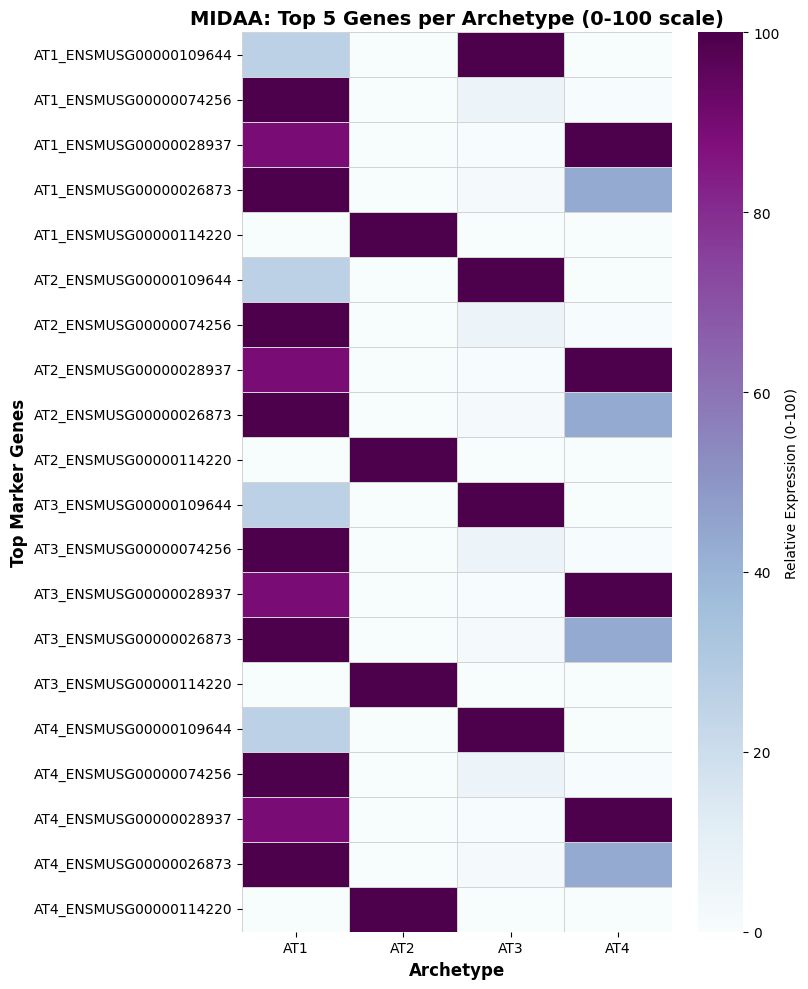

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ===========================================================================
# FIGURE 8B: TOP GENES PER ARCHETYPE (HEATMAP)
# ===========================================================================
print("\n" + "="*60)
print("CREATING FIGURE 8B: ARCHETYPE GENE SIGNATURES")
print("="*60)

gene_names = adata_beta_hfd.var_names.tolist()
top_k = 5

all_top_genes = []
heatmap_data = []

# Get full dataset for percentile calculation
if hasattr(adata_beta_hfd.X, 'toarray'):
    X_full = adata_beta_hfd.X.toarray()
else:
    X_full = np.array(adata_beta_hfd.X)

print(f"Analyzing {N_ARCHETYPES} archetypes across {len(gene_names)} genes...")

for i in range(N_ARCHETYPES):
    archetype_expr = archetypes_midaa[i, :]
    
    # Calculate percentiles (what % of cells have lower expression)
    percentiles = np.array([
        (X_full[:, j] < archetype_expr[j]).sum() / len(X_full) * 100 
        for j in range(len(archetype_expr))
    ])
    
    # Get top genes by percentile
    top_indices = np.argsort(percentiles)[-top_k:][::-1]
    
    print(f"\nArchetype {i+1} top genes:")
    for rank, idx in enumerate(top_indices):
        gene = gene_names[idx]
        print(f"  {rank+1}. {gene}: {percentiles[idx]:.1f}th percentile (expr={archetype_expr[idx]:.3f})")
        all_top_genes.append(f"AT{i+1}_{gene}")
        
        # Get expression across all archetypes for this gene
        expr_values = [archetypes_midaa[j, idx] for j in range(N_ARCHETYPES)]
        heatmap_data.append(expr_values)

# Convert to DataFrame
heatmap_df = pd.DataFrame(
    heatmap_data, 
    index=all_top_genes,
    columns=[f'AT{i+1}' for i in range(N_ARCHETYPES)]
)

print(f"\nHeatmap data shape: {heatmap_df.shape}")
print(f"Expression range: [{heatmap_df.min().min():.3f}, {heatmap_df.max().max():.3f}]")

# Normalize to 0-100 scale per row (gene)
min_vals = heatmap_df.min(axis=1)
max_vals = heatmap_df.max(axis=1)
heatmap_df_norm = (
    heatmap_df.sub(min_vals, axis=0)
    .div(max_vals - min_vals + 1e-10, axis=0)
    .mul(100)
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, max(10, top_k * N_ARCHETYPES * 0.4)))
sns.heatmap(
    heatmap_df_norm, 
    cmap='BuPu', 
    center=50, 
    cbar_kws={'label': 'Relative Expression (0-100)'},
    linewidths=0.5, 
    linecolor='lightgray',
    ax=ax, 
    vmin=0, 
    vmax=100, 
    yticklabels=True,
    fmt='.0f',
    annot=False
)
ax.set_xlabel('Archetype', fontsize=12, fontweight='bold')
ax.set_ylabel('Top Marker Genes', fontsize=12, fontweight='bold')
ax.set_title(f'MIDAA: Top {top_k} Genes per Archetype (0-100 scale)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/fig8b_gene_signatures_midaa.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{SAVE_DIR}/fig8b_gene_signatures_midaa.pdf', bbox_inches='tight')
print(f"\n✓ Saved Figure 8b to {SAVE_DIR}/fig8b_gene_signatures_midaa.png")
plt.show()
plt.close()

In [90]:
# ===========================================================================
# RECONSTRUCTION METRICS: MSE, RMSE, R²
# ===========================================================================
print("\n" + "="*60)
print("RECONSTRUCTION METRICS")
print("="*60)

# Get data
X_data = to_numpy(results['X'])
C_midaa = to_numpy(results['C_list'][0])
S_midaa = to_numpy(results['S_list'][0])

# Compute archetypes and reconstruction
archetypes_midaa = S_midaa @ X_data
X_recon_midaa = C_midaa @ archetypes_midaa

# MSE
mse = np.mean((X_data - X_recon_midaa) ** 2)

# RMSE
rmse = np.sqrt(mse)

# R²
ss_res = np.sum((X_data - X_recon_midaa) ** 2)
ss_tot = np.sum((X_data - np.mean(X_data)) ** 2)
r2 = 1 - ss_res / ss_tot

# Print results
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²:   {r2:.6f}")

print("="*60)


RECONSTRUCTION METRICS
MSE:  0.099013
RMSE: 0.314663
R²:   0.830592
